<h1> Load Date </h1>

In [2]:
# -- Import --
import sys
sys.path.append("/home/puguix/Desktop/cryptoBot/data_polo/utility/")

import numpy as np
import pandas as pd
from get_data import get_historical_from_db
import ta
import matplotlib.pyplot as plt
import numpy as np
from math import *
from IPython.display import clear_output
from time import time
from datetime import timedelta

# - - Load data from database --
df = get_historical_from_db("Binance","FTM/USDT","15m")

# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

print("Data loaded 100%")

Data loaded 100%


/tmp/ipykernel_16733/2226737475.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)


<h1> Optimisation </h1>

<h1> Backtest </h1>

In [3]:
dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
# dfTest = df['2023-02-01':]

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
dt = pd.DataFrame(columns=['date', 'position', 'reason',
                           'price', 'frais', 'wallet', 'drawBack'])

# -- You can change variables below --
leverage = 1
wallet = 1000
makerFee = 0.0002
takerFee = 0.00051

# -- Do not touch these values --
initalWallet = wallet
lastAth = wallet
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
orderInProgress = ''
longIniPrice = 0
shortIniPrice = 0
longLiquidationPrice = 500000
shortLiquidationPrice = 0

# - - Our params - -

window = 14

# - - Define our indicators - -

dfTest['plus'] = ta.trend.adx_pos(dfTest['high'], dfTest['low'], dfTest['close'], window=window)
dfTest['minus'] = ta.trend.adx_neg(dfTest['high'], dfTest['low'], dfTest['close'], window=window)


# - - Write open and close conditions here - - 

def openLongCondition(row):
    return row['plus'] > row['minus']

def closeLongCondition(row):
    return row['plus'] < row['minus']

# no shorts with this strategy
def openShortCondition(row):
    return row['plus'] < row['minus']

def closeShortCondition(row):
    return row['plus'] > row['minus']

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():

    # -- If there is an order in progress --
    if orderInProgress != '':
        # -- Check if there is a LONG order in progress --
        if orderInProgress == 'LONG':
            # -- Check Liquidation --
            if row['low'] < longLiquidationPrice:
                print('/!\ YOUR LONG HAVE BEEN LIQUIDATED the',index)
                break
            
            # -- Check If you have to close the LONG --
            if closeLongCondition(row) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] - takerFee * row['close']
                pr_change = (closePriceWithFee - longIniPrice) / longIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close LONG at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)


                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet
                
                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "LONG", 'reason': 'Close Long Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)

        # -- Check if there is a SHORT order in progress --
        elif orderInProgress == 'SHORT':
            # -- Check Liquidation --
            if row['high'] > shortLiquidationPrice:
                print('/!\ YOUR SHORT HAVE BEEN LIQUIDATED the',index)
                break

            # -- Check If you have to close the SHORT --
            if closeShortCondition(row) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] + takerFee * row['close']
                pr_change = -(closePriceWithFee - shortIniPrice) / shortIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close SHORT at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)

                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet

                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "SHORT", 'reason': 'Close Short Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)

    # -- If there is NO order in progress --
    if orderInProgress == '':
        # -- Check If you have to open a LONG --
        if openLongCondition(row) == True:
            orderInProgress = 'LONG'
            closePrice = row['close']
            longIniPrice = row['close'] + takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            longLiquidationPrice = longIniPrice - (wallet/tokenAmount)

            # -- You can uncomment the line below if you want to see logs --
            # print('Open LONG at', closePrice, '$ the', index, '| Liquidation price :', longLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Long", 'reason': 'Open Long Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)
        
        # -- Check If you have to open a SHORT --
        if openShortCondition(row) == True:
            orderInProgress = 'SHORT'
            closePrice = row['close']
            shortIniPrice = row['close'] - takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            shortLiquidationPrice = shortIniPrice + (wallet/tokenAmount)
            # -- You can uncomment the line below if you want to see logs --
            # print('Open SHORT', closePrice, '$ the', index, '| Liquidation price :', shortLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Short", 'reason': 'Open Short Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)


# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat%'] = dt['wallet'].pct_change()*100

dt['tradeIs'] = ''
dt.loc[dt['resultat%'] > 0, 'tradeIs'] = 'Good'
dt.loc[dt['resultat%'] < 0, 'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose)
holdWallet = holdPercentage * leverage * initalWallet
algoPercentage = ((wallet - initalWallet)/initalWallet)
vsHoldPercentage = ((wallet - holdWallet)/holdWallet) * 100

try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    TotalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    TotalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    TotalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    TotalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = TotalBadTrades + TotalGoodTrades

try:
    TotalLongTrades = dt.groupby('position')['date'].nunique()['LONG']
    AverageLongTrades = round(dt.loc[dt['position'] == 'LONG', 'resultat%'].sum()
                              / dt.loc[dt['position'] == 'LONG', 'resultat%'].count(), 2)
    idBestLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmax()
    bestLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].max(), 2))
    idWorstLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmin()
    worstLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].min(), 2))
except:
    AverageLongTrades = 0
    TotalLongTrades = 0
    bestLongTrade = ''
    idBestLong = ''
    idWorstLong = ''
    worstLongTrade = ''
    print("/!\ There is no LONG Trades in your BackTest, maybe a problem...")

try:
    TotalShortTrades = dt.groupby('position')['date'].nunique()['SHORT']
    AverageShortTrades = round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].sum()
                               / dt.loc[dt['position'] == 'SHORT', 'resultat%'].count(), 2)
    idBestShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmax()
    bestShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].max(), 2))
    idWorstShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmin()
    worstShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].min(), 2))
except:
    AverageShortTrades = 0
    TotalShortTrades = 0
    bestShortTrade = ''
    idBestShort = ''
    idWorstShort = ''
    worstShortTrade = ''
    print("/!\ There is no SHORT Trades in your BackTest, maybe a problem...")

try:
    totalGoodLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Good']
except:
    totalGoodLongTrade = 0
    print("/!\ There is no good LONG Trades in your BackTest, maybe a problem...")

try:
    totalBadLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Bad']
except:
    totalBadLongTrade = 0
    print("/!\ There is no bad LONG Trades in your BackTest, maybe a problem...")

try:
    totalGoodShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Good']
except:
    totalGoodShortTrade = 0
    print("/!\ There is no good SHORT Trades in your BackTest, maybe a problem...")

try:
    totalBadShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Bad']
except:
    totalBadShortTrade = 0
    print("/!\ There is no bad SHORT Trades in your BackTest, maybe a problem...")

TotalTrades = TotalGoodTrades + TotalBadTrades
winRateRatio = (TotalGoodTrades/TotalTrades) * 100

reasons = dt['reason'].unique()

print("BackTest finished, final wallet :",wallet,"$")
#dt


/home/puguix/.local/lib/python3.10/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[
/home/puguix/.local/lib/python3.10/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[


BackTest finished, final wallet : 8.690895412090272e-05 $


<h1>Print Complete BackTest Analyses</h1>

Pair Symbol : ETH/USDT
Period : [2019-06-11 04:00:00] -> [2022-11-11 15:30:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 0.0 $
Hold balance : 3869.12 $
Performance vs US Dollar : -100.0 %
Buy and Hold Performence : 386.91 % | with Leverage : 386.91 %
Performance vs Buy and Hold : -100.0 %
Best trade : +84.96 %, the  2021-01-24 19:30:00
Worst trade : -12.28 %, the  2021-01-29 11:30:00
Worst drawBack : -100.0 %
Total fees :  1631.19 $

----- Trades Informations -----
Total trades on period : 9948
Number of positive trades : 2638
Number of negative trades :  7310
Trades win rate ratio : 26.52 %
Average trades performance : -0.11 %
Average positive trades : 2.94 %
Average negative trades : -1.21 %

----- LONG Trades Informations -----
Number of LONG trades : 4974
Average LONG trades performance : -0.04 %
Best  LONG trade +84.96 %, the  2021-01-24 19:30:00
Worst LONG trade -12.28 %, the  2021-01-29 11:30:00
Number of positive LONG trades : 1303
Number of ne

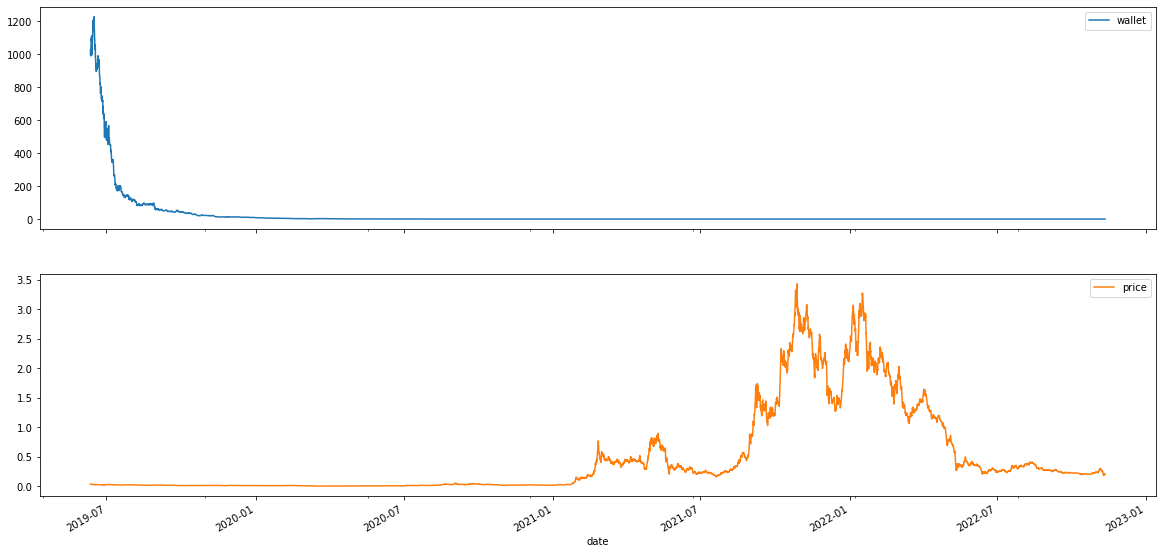

In [4]:
print("Pair Symbol :","ETH/USDT",)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Hold balance :", round(holdWallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage*100, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage*100, 2),
      "% | with Leverage :", round(holdPercentage*100, 2)*leverage, "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the ", idbest)
print("Worst trade :", worstTrade, "%, the ", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 2)), "%")
print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", TotalGoodTrades)
print("Number of negative trades : ", TotalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- LONG Trades Informations -----")
print("Number of LONG trades :",TotalLongTrades)
print("Average LONG trades performance :",AverageLongTrades, "%")
print("Best  LONG trade +"+bestLongTrade, "%, the ", idBestLong)
print("Worst LONG trade", worstLongTrade, "%, the ", idWorstLong)
print("Number of positive LONG trades :",totalGoodLongTrade)
print("Number of negative LONG trades :",totalBadLongTrade)
print("LONG trade win rate ratio :", round(totalGoodLongTrade/TotalLongTrades*100, 2), '%')

print("\n----- SHORT Trades Informations -----")
print("Number of SHORT trades :",TotalShortTrades)
print("Average SHORT trades performance :",AverageShortTrades, "%")
print("Best  SHORT trade +"+bestShortTrade, "%, the ", idBestShort)
print("Worst SHORT trade", worstShortTrade, "%, the ", idWorstShort)
print("Number of positive SHORT trades :",totalGoodShortTrade)
print("Number of negative SHORT trades :",totalBadShortTrade)
print("SHORT trade win rate ratio :", round(totalGoodShortTrade/TotalShortTrades*100, 2), '%')

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])
    
dt[['wallet', 'price']].plot(subplots=True, figsize=(20, 10))
print("\n----- Plot -----")